In [1]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


import matplotlib.pyplot as plt
import splitfolders
import os

In [2]:
input_folder  = "lung_cancer_dataset"
output_folder = "lung_cancer_dataset_filtered"

model_path   = "sub_classifying_lung_cancer.keras"

target_size   = (256,256)
input_shape = (None, 256, 256, 3)

train_path    = 'lung_cancer_dataset_filtered/train'
val_path      = 'lung_cancer_dataset_filtered/val'
test_path     = 'lung_cancer_dataset_filtered/test'

In [3]:
print(tf.__version__)

2.16.1


In [4]:
def split_dataset(input_folder, output_folder):
    '''
        Function to split the dataset into training, validation and test
    '''
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    try:
        splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8, .1, .1))
        print("Dataset split successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [5]:
split_dataset(input_folder, output_folder)

Copying files: 10000 files [00:05, 1807.41 files/s]

Dataset split successfully.


In [6]:
train_datagen  = ImageDataGenerator(rescale            = 1./255,
                                    shear_range        = 0.2,
                                    zoom_range         = 0.2,
                                    horizontal_flip    = True,
                                   )

# Validation and test data generators with rescaling only
val_datagen  = ImageDataGenerator(rescale  = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [7]:
# Prepare batches of data for training
train_data_gen = train_datagen.flow_from_directory(train_path,
                                               target_size=target_size,
                                               batch_size=40,
                                               class_mode='binary')
# Prepare batches of data for validation
val_data_gen = val_datagen.flow_from_directory(val_path,
                                               target_size=target_size,
                                               batch_size=20,
                                               class_mode='binary',
                                               shuffle=False)

# Prepare batches of data for testing on unknown samples (not used for training/validation)
test_data_gen = test_datagen.flow_from_directory(test_path,
                                               target_size=target_size,
                                               batch_size=20,
                                               class_mode='binary',
                                               shuffle=False)

Found 8000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
def plotImages(images_arr):
    '''
        This function will plot images in the form of a grid with 4 rows and 4 columns 
    '''
    fig, axes = plt.subplots(4, 4, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

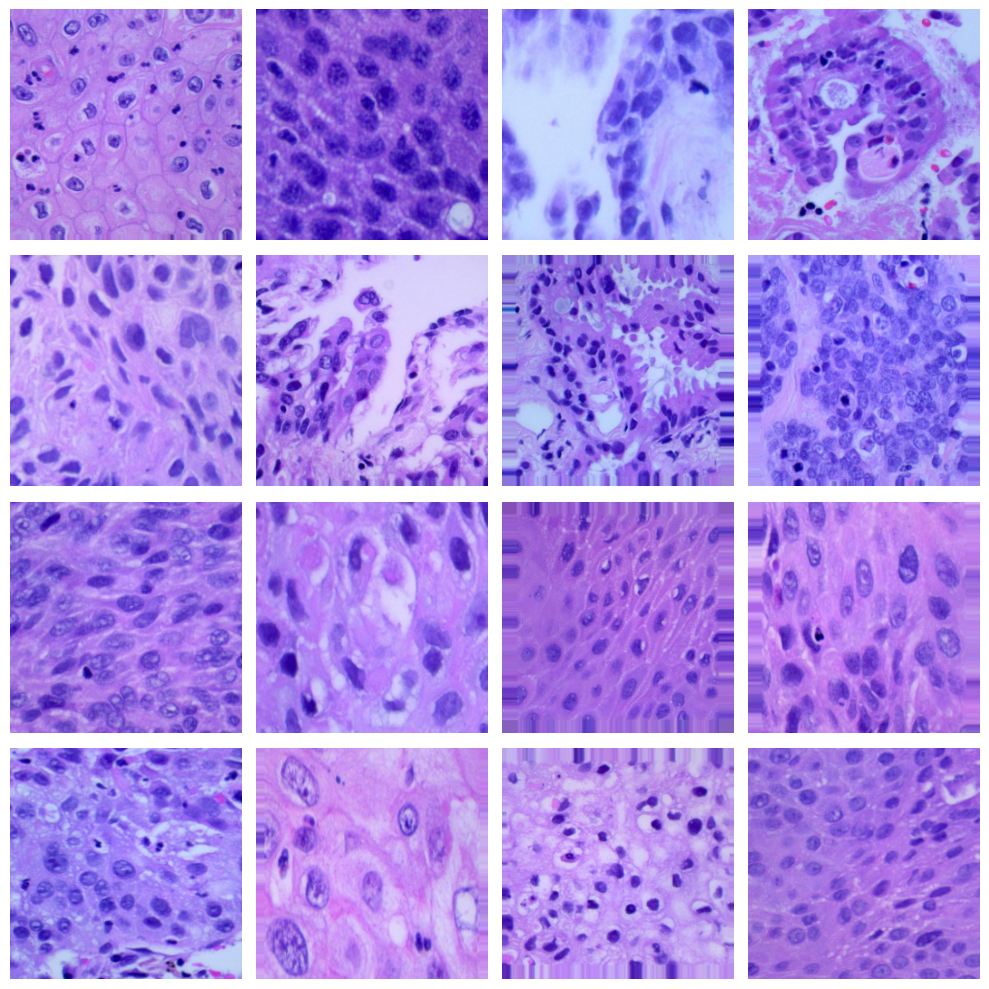

In [10]:
# The next function returns a batch from the training dataset. We use image data and discard the labels.
sample_training_images, _ = next(train_data_gen)

# Plot 16 random images from training data    
plotImages(sample_training_images[:16])

In [11]:
@keras.saving.register_keras_serializable(package="MyLayers")
class CustomModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super(CustomModel, self).__init__(**kwargs)
        self.conv1    = Conv2D(filters = 32, kernel_size = (3,3) , activation = "relu")
        self.maxpool1 = MaxPooling2D(pool_size = (2,2))
        self.conv2    = Conv2D(filters = 64, kernel_size = (3,3) , activation = "relu")
        self.maxpool2 = MaxPooling2D(pool_size = (2,2))
        self.conv3    = Conv2D(filters = 128, kernel_size = (3,3) , activation = "relu")
        self.maxpool3 = MaxPooling2D(pool_size = (2,2))
        self.flatten  = Flatten()
        self.dense1   = Dense(128, activation="relu")
        self.dropout1 = Dropout(0.2)
        self.dense2   = Dense(1, activation="sigmoid")

    def build(self, input_shape):
        input_tensor = Input(shape = input_shape[1:])
        self.call(input_tensor)
        super(CustomModel,self).build(input_tensor)

    def call(self,input):
        x = self.conv1(input)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        return x

    def get_config(self):
        config = super(CustomModel, self).get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [12]:
model = CustomModel()

In [13]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [14]:
model.build(input_shape)

In [15]:
model.summary()

Model: "custom_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,105 (56.61 MB)

 Trainable params: 14,839,105 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model_checkpoint_callback = ModelCheckpoint(filepath = model_path, monitor = 'val_accuracy', 
                                            save_best_only = True, mode ='max', verbose = 1)
early_stopping_callback   = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True, mode = 'max')

epochs  = 20
history = model.fit(train_data_gen,
                    epochs = epochs,
                    validation_data = val_data_gen,
                    callbacks = [model_checkpoint_callback, early_stopping_callback])

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7368 - loss: 0.4985
Epoch 1: val_accuracy improved from -inf to 0.87300, saving model to sub_classifying_lung_cancer.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - accuracy: 0.7372 - loss: 0.4980 - val_accuracy: 0.8730 - val_loss: 0.3040
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8795 - loss: 0.2931
Epoch 2: val_accuracy did not improve from 0.87300
200/200 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - accuracy: 0.8795 - loss: 0.2932 - val_accuracy: 0.8650 - val_loss: 0.2949
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8922 - loss: 0.2617
Epoch 3: val_accuracy improved from 0.87300 to 0.92300, saving model to sub_classifying_lung_cancer.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - accuracy: 0.8922 - loss: 0.2616 - val_accuracy: 0.9230 - val_loss: 0.1902
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9078 - loss: 0.2232
Epoch 4: val_accuracy did not improve from 0.9

2024-06-03 08:13:37.092821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 1 of 8
2024-06-03 08:13:40.753586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 82s/step - accuracy: 0.9762 - loss: 0.0690  
Epoch 15: val_accuracy did not improve from 0.97600
200/200 ━━━━━━━━━━━━━━━━━━━━ 16966s 82s/step - accuracy: 0.9762 - loss: 0.0690 - val_accuracy: 0.9670 - val_loss: 0.0911
Epoch 16/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9671 - loss: 0.0944
Epoch 16: val_accuracy did not improve from 0.97600
200/200 ━━━━━━━━━━━━━━━━━━━━ 509s 3s/step - accuracy: 0.9671 - loss: 0.0943 - val_accuracy: 0.9690 - val_loss: 0.0870
Epoch 17/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9766 - loss: 0.0634
Epoch 17: val_accuracy did not improve from 0.97600
200/200 ━━━━━━━━━━━━━━━━━━━━ 510s 3s/step - accuracy: 0.9766 - loss: 0.0634 - val_accuracy: 0.9700 - val_loss: 0.1163
Epoch 18/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9812 - loss: 0.0572
Epoch 18: val_accuracy improved from 0.97600 to 0.98200, saving model to sub_classifying_lung_cancer.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 795s 4s/step - a

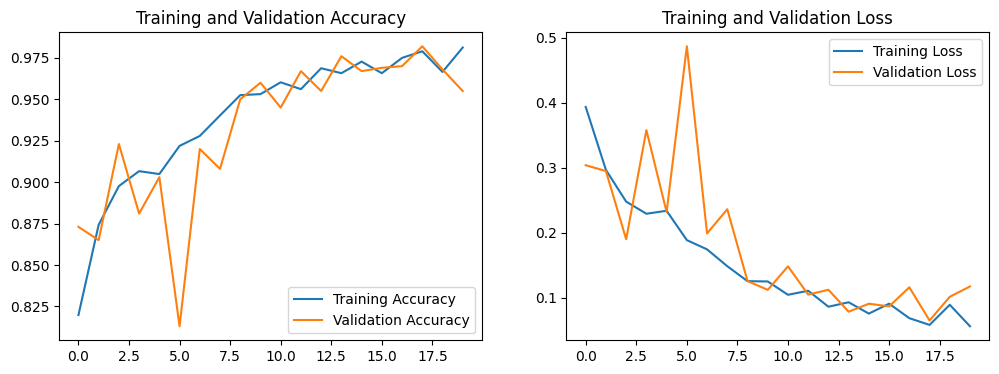

In [18]:
# Plot model accuracy and loss
train_acc  = history.history['accuracy']
val_acc    = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss   = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
trained_model = load_model(model_path, custom_objects={'CustomModel': CustomModel})

In [20]:
# Test your model on unknown samples (testing data)
train_loss, train_acc = model.evaluate(train_data_gen)
print('Train accuracy:', train_acc)
print('Train loss:', train_loss)

200/200 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.9793 - loss: 0.0545
Train accuracy: 0.9794999957084656
Train loss: 0.05238278955221176


In [21]:
# Test your model on unknown samples (testing data)
val_loss, val_acc = model.evaluate(val_data_gen)
print('Val accuracy:', val_acc)
print('Val loss:', val_loss)

50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 711ms/step - accuracy: 0.9820 - loss: 0.0808
Val accuracy: 0.9819999933242798
Val loss: 0.06535542756319046


In [22]:
# Test your model on unknown samples (testing data)
test_loss, test_acc = model.evaluate(test_data_gen)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 750ms/step - accuracy: 0.9582 - loss: 0.1374
Test accuracy: 0.9670000076293945
Test loss: 0.09481397271156311
